# **Part 1: Code**

In [37]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# encodes string to numeric
def encode_labels(y):
	encoder = LabelEncoder()
	y_encoded = encoder.fit_transform(y)

	# convert to -1/+1 if binary
	if len(encoder.classes_) == 2:
		y_encoded = y_encoded * 2 - 1

	return y_encoded, encoder

# decodes numeric labels back to string
def decode_labels(y_encoded, encoder):
	# handle -1/+1 → 0/1 if binary
	if len(encoder.classes_) == 2 and set(np.unique(y_encoded)) == {-1, 1}:
		y_encoded = (np.array(y_encoded) + 1) // 2

	return encoder.inverse_transform(y_encoded)


## Results:

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 
  
# data (as pandas dataframes) 
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features 
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets

# Convert target to 1D array
y = y.values.ravel()

# column infos
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer(
	transformers=[
		('num', StandardScaler(), numerical_cols),
		('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
	]
)

y_encoded, encoder = encode_labels(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# preprocess the dataset and convert to np arrays
X_full_preprocessed_np = preprocessor.fit_transform(X)

## Conclusions:
I chose the Estimation of Obesity Levels Based on Eating Habits and Physical Condition dataset because it’s both interesting and practical, focusing on real-world health-related behavior. It’s a multiclass classification problem with a mix of numerical and categorical features, making it suitable for evaluating different models. The class distribution is moderately imbalanced, which helps test model robustness.

# **Part 2: Code**

In [39]:
import time
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

RANDOM_STATE = 91 # for k-fold cross-validation

def adaboost_mlp(X, y, T, numerical_cols, categorical_cols, max_mlp_iter=1000):
	n_samples = X.shape[0]
	weights = np.ones(n_samples) / n_samples

	mlps = []
	alphas = []

	y_np = np.array(y)
 
	# labels
	class_labels = np.unique(y_np)
 
	# Check if binary or multiclass
	is_binary = len(class_labels) == 2
	if is_binary:
		label_map = {class_labels[0]: -1, class_labels[1]: 1}
		y_numeric = np.array([label_map[yi] for yi in y_np])
	else:
		label_map = {label: idx for idx, label in enumerate(class_labels)}
		y_numeric = np.array([label_map[yi] for yi in y_np])

	for t in range(T):
		# resample data based on weights similar to bootstarping
		indices = np.random.choice(np.arange(n_samples), size=n_samples, replace=True, p=weights)
		X_sample = X.iloc[indices]
		y_sample = y_np[indices]

		# define preprocessor for each round
		# idk why but it resolved my bug
		preprocessor = ColumnTransformer(transformers=[
			('num', StandardScaler(), numerical_cols),
			('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
		])

		mlp_pipeline = Pipeline(steps=[
			('preprocessor', preprocessor),
			('classifier', MLPClassifier(hidden_layer_sizes=(1,),
										 max_iter=max_mlp_iter,
										 random_state=time.time_ns() % (2**32)))
		])

		mlp_pipeline.fit(X_sample, y_sample)

		# Predict on full training data
		y_pred = mlp_pipeline.predict(X)
		y_pred_numeric = np.array([label_map[yi] for yi in y_pred])

		# weighted error
		error = np.sum(weights * (y_numeric != y_pred_numeric)) / np.sum(weights)

		if error >= 1 - (1 / len(class_labels)):
			print("Skipping this weak learner due to high error.")
			continue

		alpha = 0.5 * np.log((1 - error) / (error + 1e-10))

		weights *= np.exp(-alpha * (y_numeric == y_pred_numeric).astype(int) * 2 - 1)
		weights /= np.sum(weights)  # Normalize

		mlps.append(mlp_pipeline)
		alphas.append(alpha)

	return mlps, alphas

def predict_adaboost(X, classifiers, alphas):
	n_samples = len(X)
 
	# map classes
	classes = classifiers[0].named_steps['classifier'].classes_
	class_indices = {label: idx for idx, label in enumerate(classes)}
 
	K = len(classes)

	# majority vote
	votes = np.zeros((n_samples, K))

	for clf, alpha in zip(classifiers, alphas):
		pred = clf.predict(X)
  
		# create an array of indices of classes
		pred_idx = np.array([class_indices[p] for p in pred])
		votes[np.arange(n_samples), pred_idx] += alpha

	y_pred_indices = np.argmax(votes, axis=1)
	return np.array([classes[i] for i in y_pred_indices])

# k-fold cross-validation
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix

def k_fold_cross_validation_adaboost_mlp(X: pd.DataFrame, y_encoded, encoder, k_fold=5, T=5,
                                         numerical_cols=None, categorical_cols=None, random_state=None):
    if k_fold < 1:
        raise ValueError("k_fold must be greater than 0")
    if len(y_encoded) == 0:
        raise ValueError("data must not be empty")
    if k_fold > len(y_encoded):
        k_fold = len(y_encoded)

    indices = list(range(len(y_encoded)))
    if random_state is not None:
        np.random.seed(random_state)
    np.random.shuffle(indices)

    fold_size = len(y_encoded) // k_fold
    confusion_matrices = []
    accuracies = []

    start_time = time.time()

    for i in range(k_fold):
        test_indices = indices[i * fold_size:(i + 1) * fold_size]
        train_indices = [j for j in indices if j not in test_indices]

        X_train_fold = X.iloc[train_indices]
        y_train_fold = y_encoded[train_indices]
        X_test_fold = X.iloc[test_indices]
        y_test_fold = y_encoded[test_indices]

        mlps, alphas = adaboost_mlp(X_train_fold, y_train_fold, T=T,
                                     numerical_cols=numerical_cols, categorical_cols=categorical_cols)

        y_pred_fold = predict_adaboost(X_test_fold, mlps, alphas)

        # for comparision
        y_true_decoded = decode_labels(y_test_fold, encoder)
        y_pred_decoded = decode_labels(y_pred_fold, encoder)

        acc = accuracy_score(y_true_decoded, y_pred_decoded)
        accuracies.append(acc)

        cm = confusion_matrix(y_true_decoded, y_pred_decoded, labels=encoder.classes_)
        confusion_matrices.append(cm)

    elapsed_time = time.time() - start_time
    avg_accuracy = sum(accuracies) / len(accuracies)

    return confusion_matrices, avg_accuracy, elapsed_time

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrices(confusion_matrices, class_labels, normalize=False):
	num_folds = len(confusion_matrices)

	fig, axes = plt.subplots(1, num_folds, figsize=(5 * num_folds, 5))

	if num_folds == 1:
		axes = [axes]  # make it iterable

	for i, (cm, ax) in enumerate(zip(confusion_matrices, axes)):
		if normalize:
			cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
			cm = np.nan_to_num(cm)  # handle division by zero

		sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
					xticklabels=class_labels, yticklabels=class_labels,
					cmap="Blues", ax=ax)

		ax.set_title(f"Fold {i+1}")
		ax.set_xlabel("Predicted Label")
		ax.set_ylabel("True Label")

	plt.tight_layout()
	plt.show()

## Results:

Avg Accuracy: 0.8431, Time: 44.50 sec for T = 5


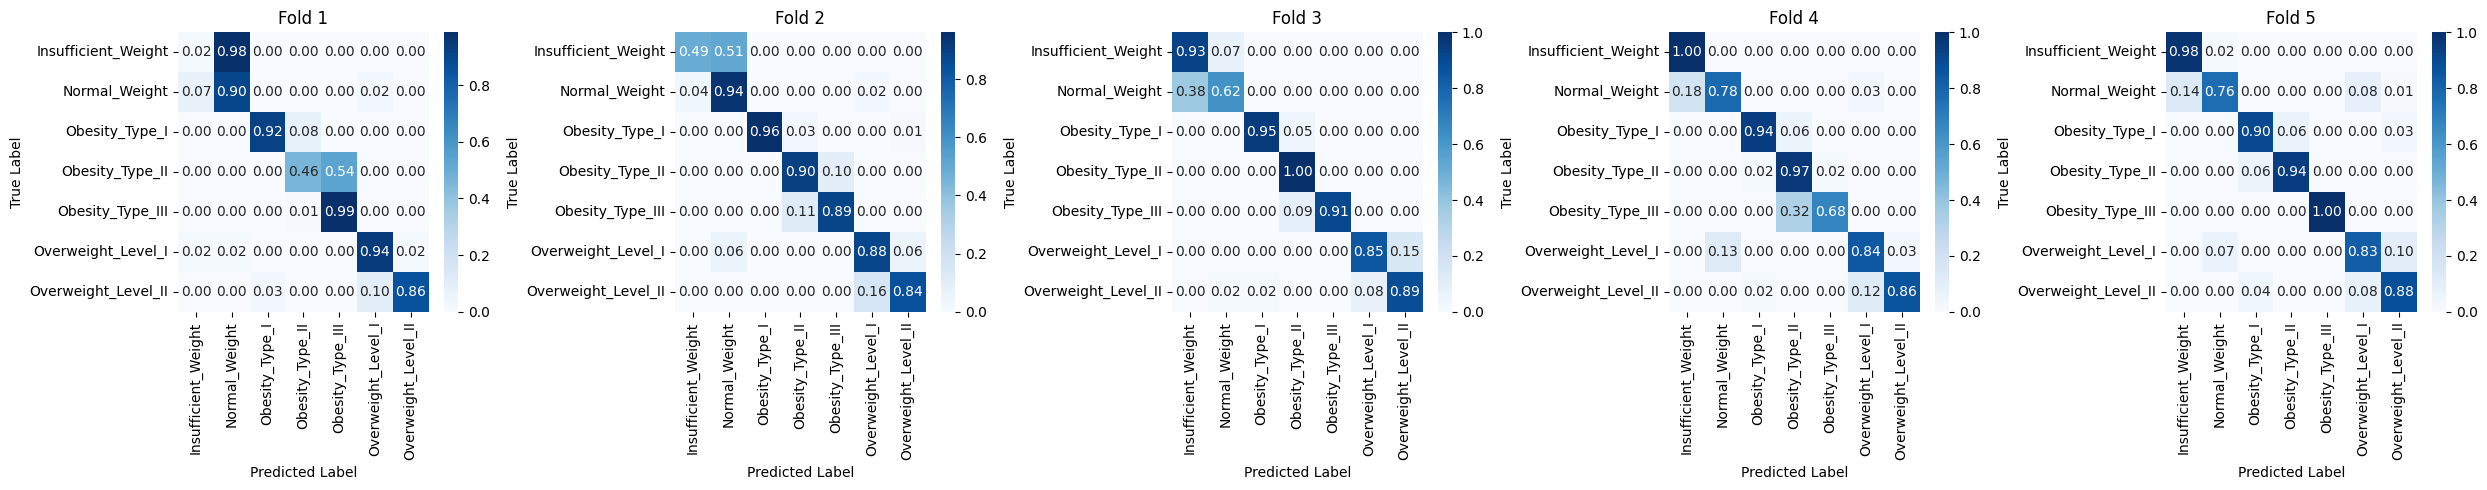

Avg Accuracy: 0.8957, Time: 141.70 sec for T = 15


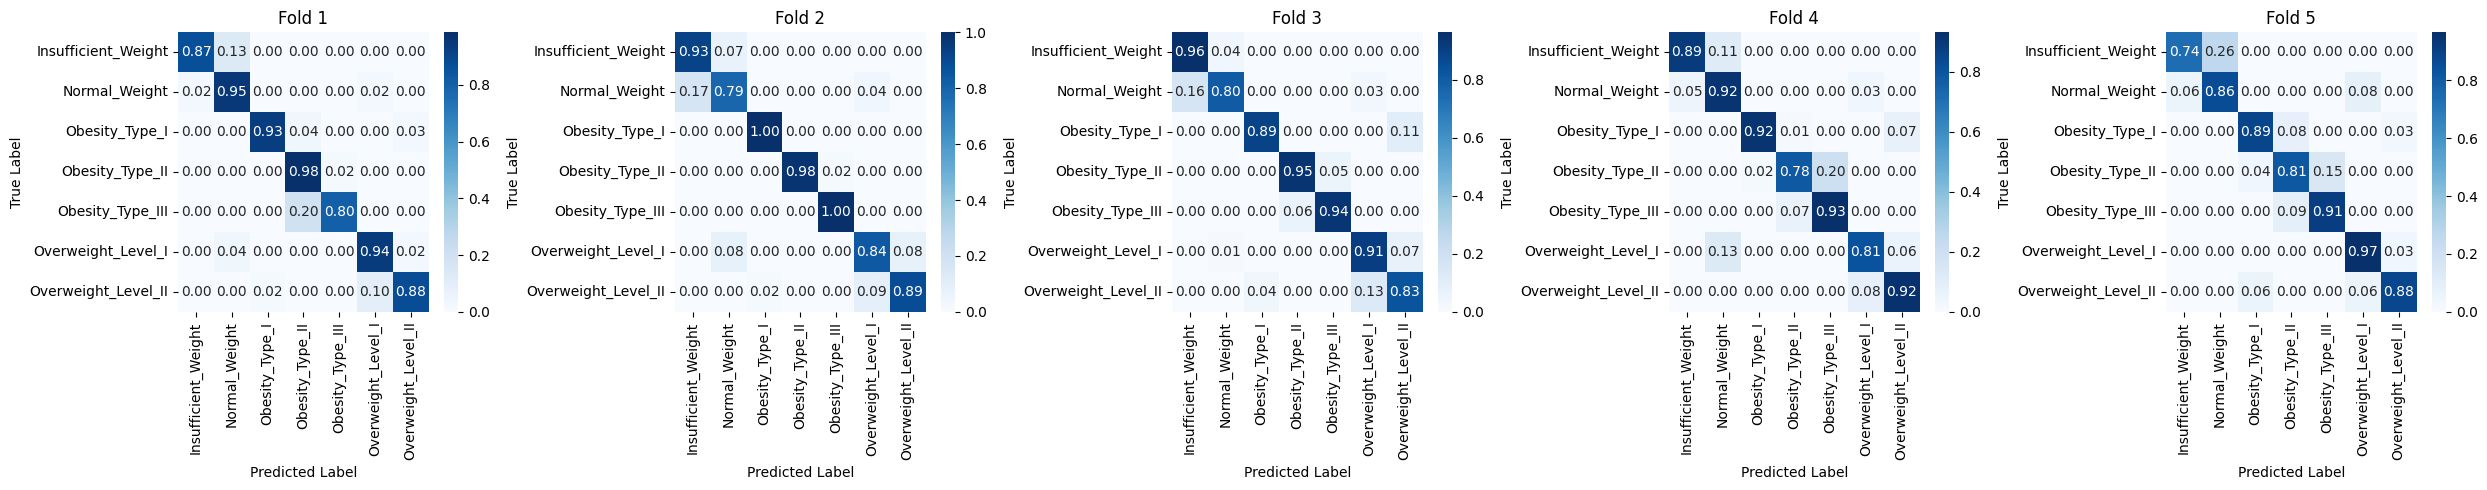

Avg Accuracy: 0.9256, Time: 268.25 sec for T = 30


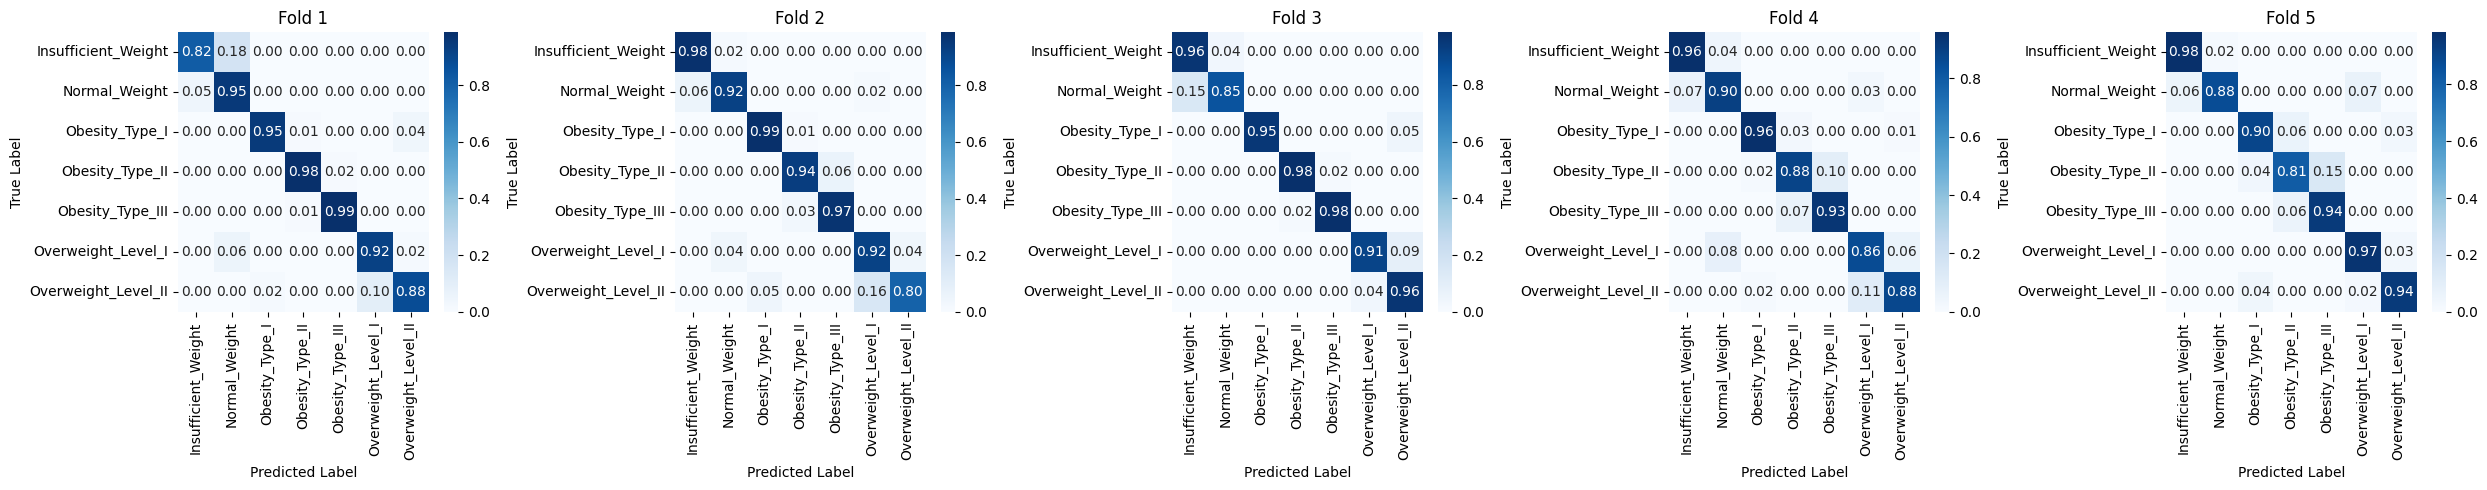

In [44]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

conf_matrices, avg_acc, duration = k_fold_cross_validation_adaboost_mlp(
    X, y_encoded, encoder,
    k_fold=5,
    T=5,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    random_state=RANDOM_STATE
)
print(f"Avg Accuracy: {avg_acc:.4f}, Time: {duration:.2f} sec for T = 5")
plot_confusion_matrices(conf_matrices, encoder.classes_, normalize=True)

conf_matrices_15, avg_acc_15, duration_15 = k_fold_cross_validation_adaboost_mlp(
    X, y_encoded, encoder,
    k_fold=5,
    T=15,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    random_state=RANDOM_STATE
)
print(f"Avg Accuracy: {avg_acc_15:.4f}, Time: {duration_15:.2f} sec for T = 15")
plot_confusion_matrices(conf_matrices_15, encoder.classes_, normalize=True)

conf_matrices_30, avg_acc_30, duration_30 = k_fold_cross_validation_adaboost_mlp(
    X, y_encoded, encoder,
    k_fold=5,
    T=30,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    random_state=RANDOM_STATE
)
print(f"Avg Accuracy: {avg_acc_30:.4f}, Time: {duration_30:.2f} sec for T = 30")
plot_confusion_matrices(conf_matrices_30, encoder.classes_, normalize=True)

## Conclusions:



The reason behind choosing just one hidden layer in each MLP is to intentionally keep each model weak.
This aligns with the principle of AdaBoost, which relies on combining many weak learners to form a strong ensemble. Using a shallow MLP ensures that each individual learner does not overfit and instead contributes complementary errors to the boosting process.

The accuracies consistently increase as the number of estimators (T) increases, since AdaBoost iteratively focuses on the mistakes made by previous models, gradually improving performance.

However, when T = 30, the accuracy increase slows down significantly.
This happens because the ensemble starts to saturate, the additional models are not learning much new information, as most of the difficult samples have already been accounted for.

# **Part 3: Code**

In [41]:
import numpy as np
from sklearn.linear_model import Perceptron
from collections import Counter

# recursive
def train_perceptron_node(X, y, depth, max_depth, max_prec_iter=1000):
    if depth >= max_depth or len(set(y)) == 1:
        return {'label': Counter(y).most_common(1)[0][0]}

    classes = list(set(y))
    split = (classes[:len(classes)//2], classes[len(classes)//2:])
    binary_y = np.array([0 if label in split[0] else 1 for label in y])

    model = Perceptron(max_iter=max_prec_iter, tol=1e-3) # tolerance: stoping criterion
    model.fit(X, binary_y)

    preds = model.predict(X)
    left_mask = preds == 0
    right_mask = preds == 1

    if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
        return {'label': Counter(y).most_common(1)[0][0]}

    return {
        'perceptron': model,
        'left': train_perceptron_node(X[left_mask], y[left_mask], depth + 1, max_depth),
        'right': train_perceptron_node(X[right_mask], y[right_mask], depth + 1, max_depth)
    }

# takes trained node
def predict_perceptron_node(tree, x):
    while 'label' not in tree:
        pred = tree['perceptron'].predict([x])[0]
        tree = tree['left'] if pred == 0 else tree['right']
    return tree['label']

# simply train lots of trees
def train_forest(X, y, n_trees, max_depth, M):
    F = X.shape[1]
    forest = []
    feature_indices = []
    for _ in range(n_trees):
        idx = np.random.choice(F, M, replace=False)
        tree = train_perceptron_node(X[:, idx], y, 0, max_depth)
        forest.append(tree)
        feature_indices.append(idx)
    return forest, feature_indices

# majority vote is used
def predict_forest(forest, feature_indices, X):
    preds = []
    for i in range(X.shape[0]):
        votes = [
            predict_perceptron_node(tree, X[i, idx])
            for tree, idx in zip(forest, feature_indices)
        ]
        preds.append(Counter(votes).most_common(1)[0][0])
    return np.array(preds)


### k-fold cross-validation
import time
from sklearn.metrics import accuracy_score, confusion_matrix

def k_fold_cross_validation_perceptron_forest(X, y, encoder,
                                              k_fold=5, n_trees=50, max_depth=10, M=10,
                                              random_state=None):
    if k_fold < 1:
        raise ValueError("k_fold must be greater than 0")
    if len(y) == 0:
        raise ValueError("data must not be empty")
    if k_fold > len(y):
        k_fold = len(y)

    indices = list(range(len(y)))
    if random_state is not None:
        np.random.seed(random_state)
    np.random.shuffle(indices)

    fold_size = len(y) // k_fold
    confusion_matrices = []
    accuracies = []

    start_time = time.time()

    for i in range(k_fold):
        test_indices = indices[i * fold_size:(i + 1) * fold_size]
        train_indices = [j for j in indices if j not in test_indices]

        X_train_fold = X[train_indices]
        y_train_fold = y[train_indices]
        X_test_fold = X[test_indices]
        y_test_fold = y[test_indices]

        forest, feature_indices = train_forest(X_train_fold, y_train_fold,
                                               n_trees=n_trees,
                                               max_depth=max_depth,
                                               M=M)

        y_pred_fold = predict_forest(forest, feature_indices, X_test_fold)

        y_true_decoded = encoder.inverse_transform(y_test_fold)
        y_pred_decoded = encoder.inverse_transform(y_pred_fold)

        acc = accuracy_score(y_true_decoded, y_pred_decoded)
        accuracies.append(acc)

        cm = confusion_matrix(y_true_decoded, y_pred_decoded, labels=encoder.classes_)
        confusion_matrices.append(cm)

    elapsed_time = time.time() - start_time
    avg_accuracy = np.mean(accuracies)

    return confusion_matrices, avg_accuracy, elapsed_time



## Results:

Avg Accuracy: 0.5545, Time: 38.67 sec for T = 50


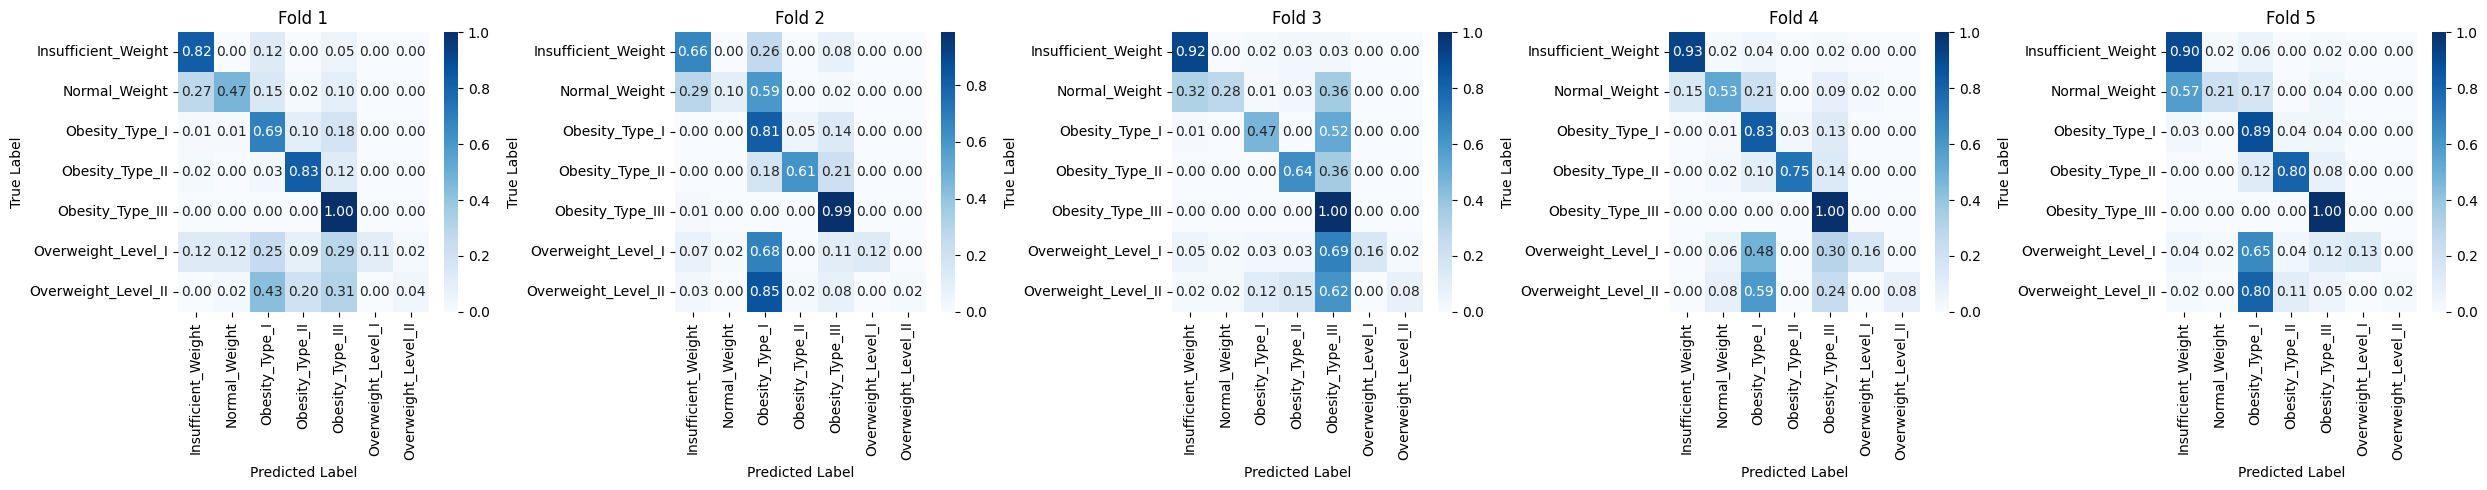

Avg Accuracy: 0.8393, Time: 70.26 sec for T = 100


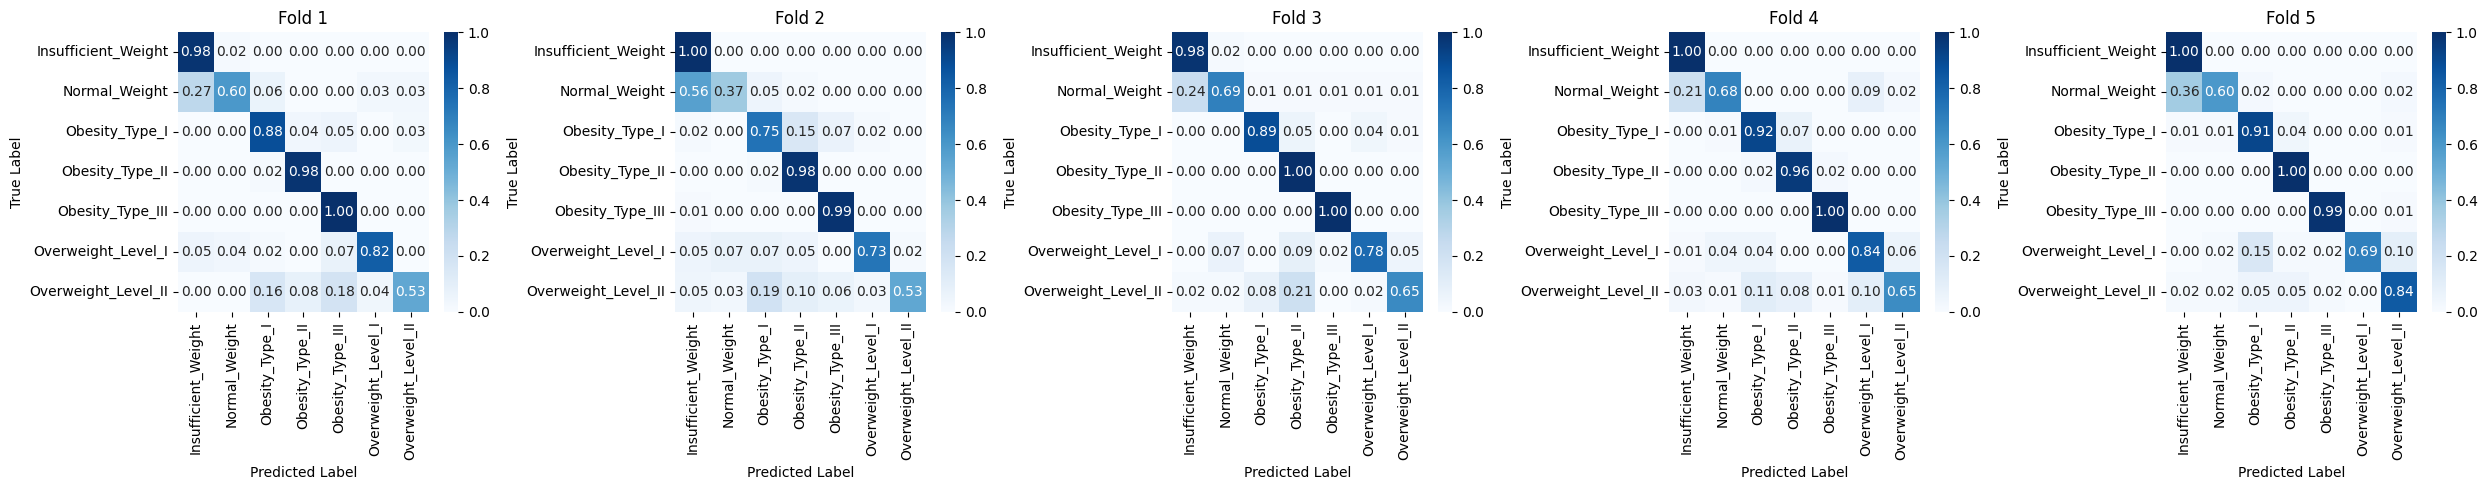

Avg Accuracy: 0.9213, Time: 80.79 sec for T = 150


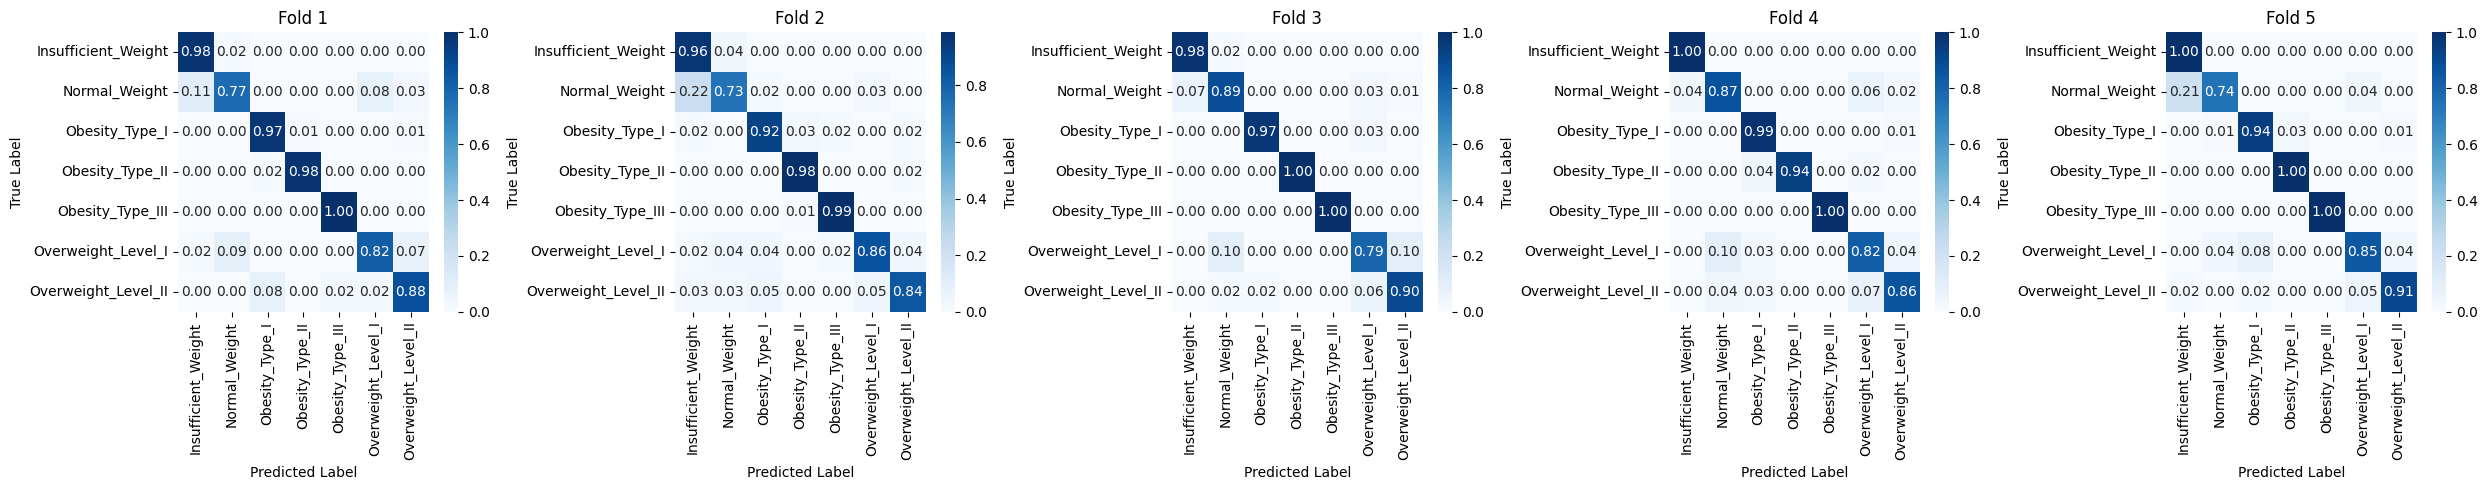

Avg Accuracy: 0.5545, Time: 44.07 sec for M = 6


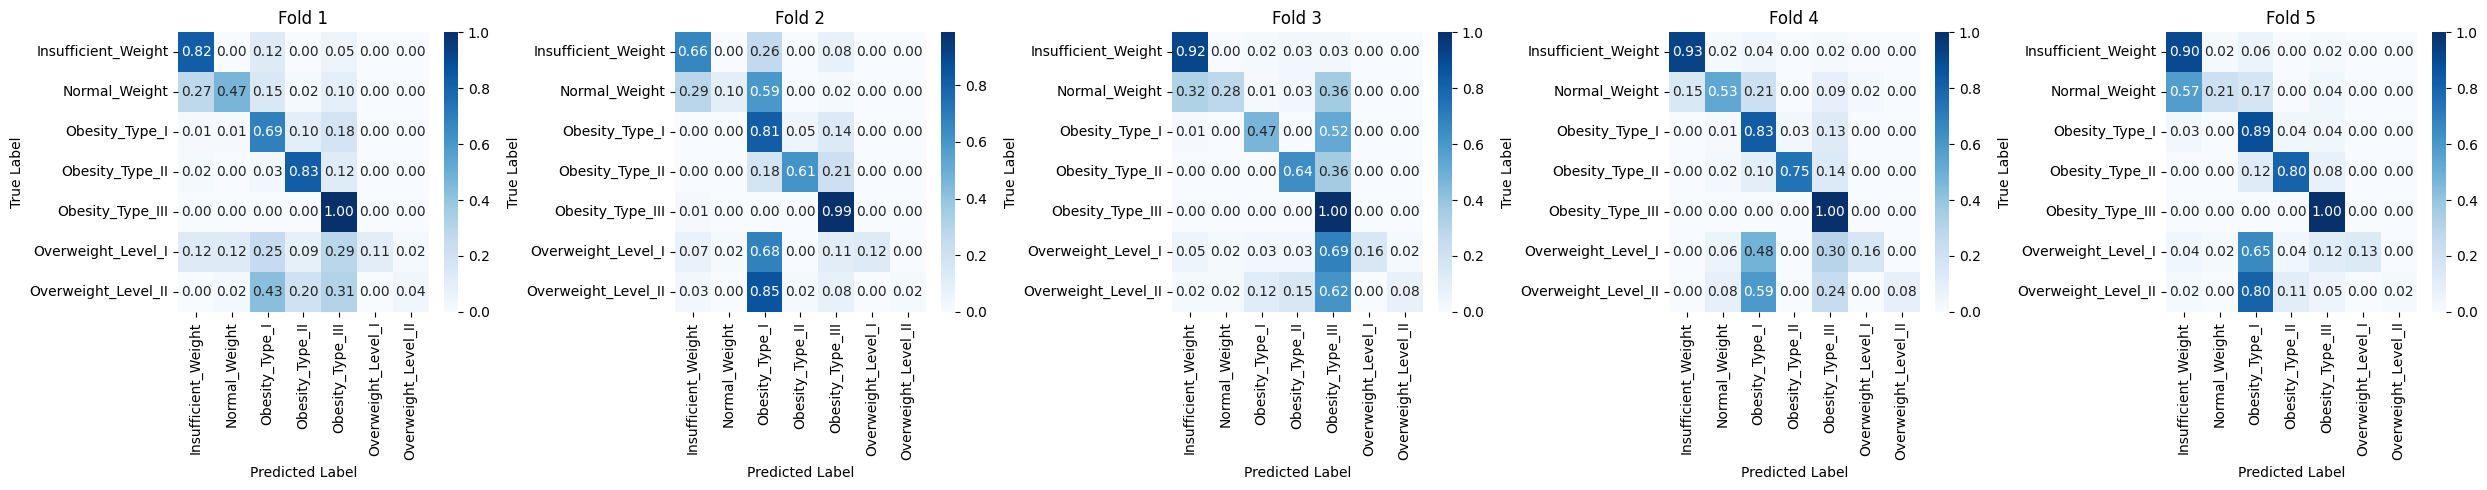

Avg Accuracy: 0.8393, Time: 71.88 sec for M = 12


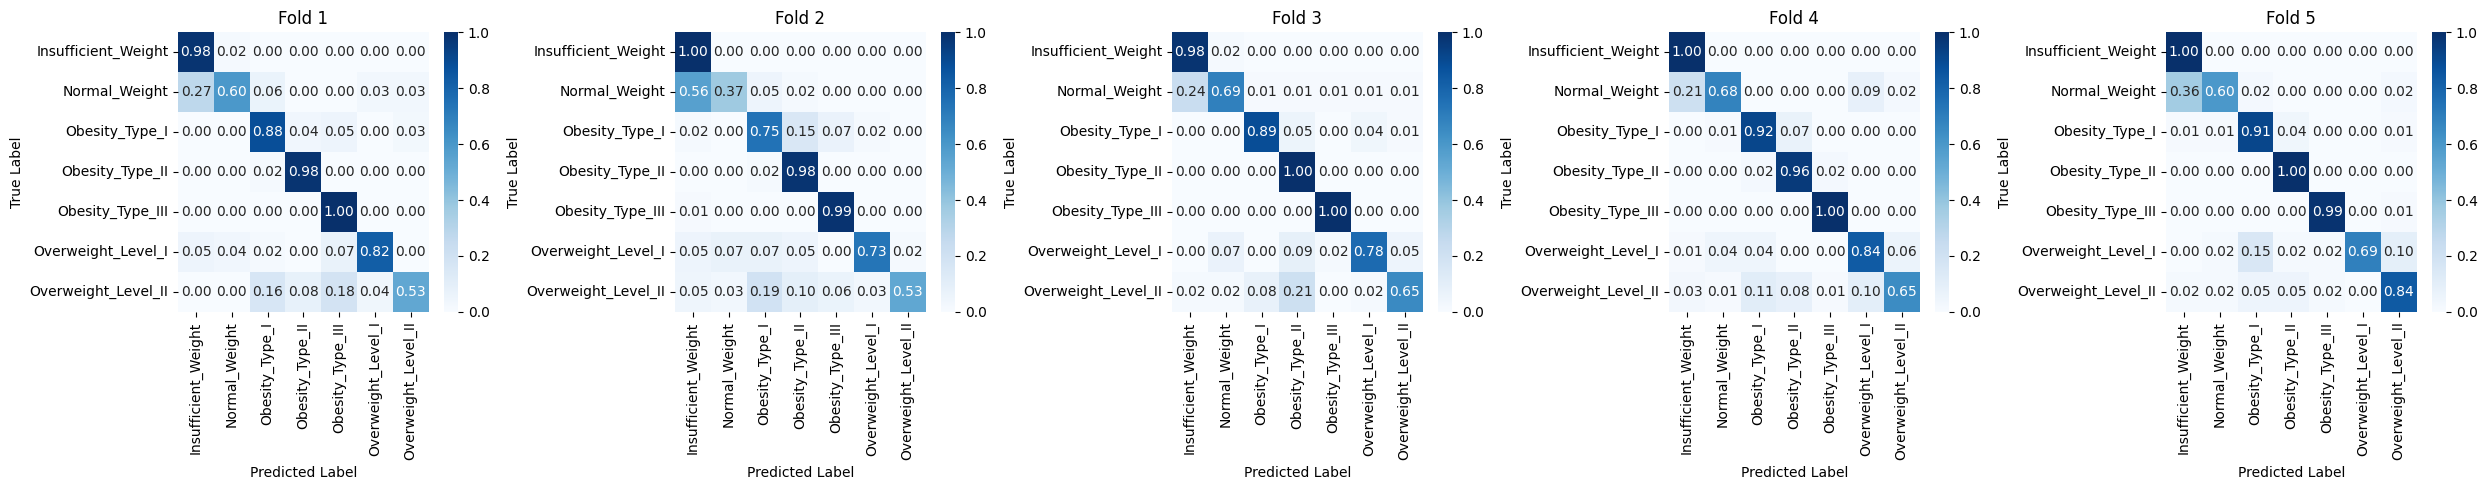

Avg Accuracy: 0.9213, Time: 90.64 sec for M = 18


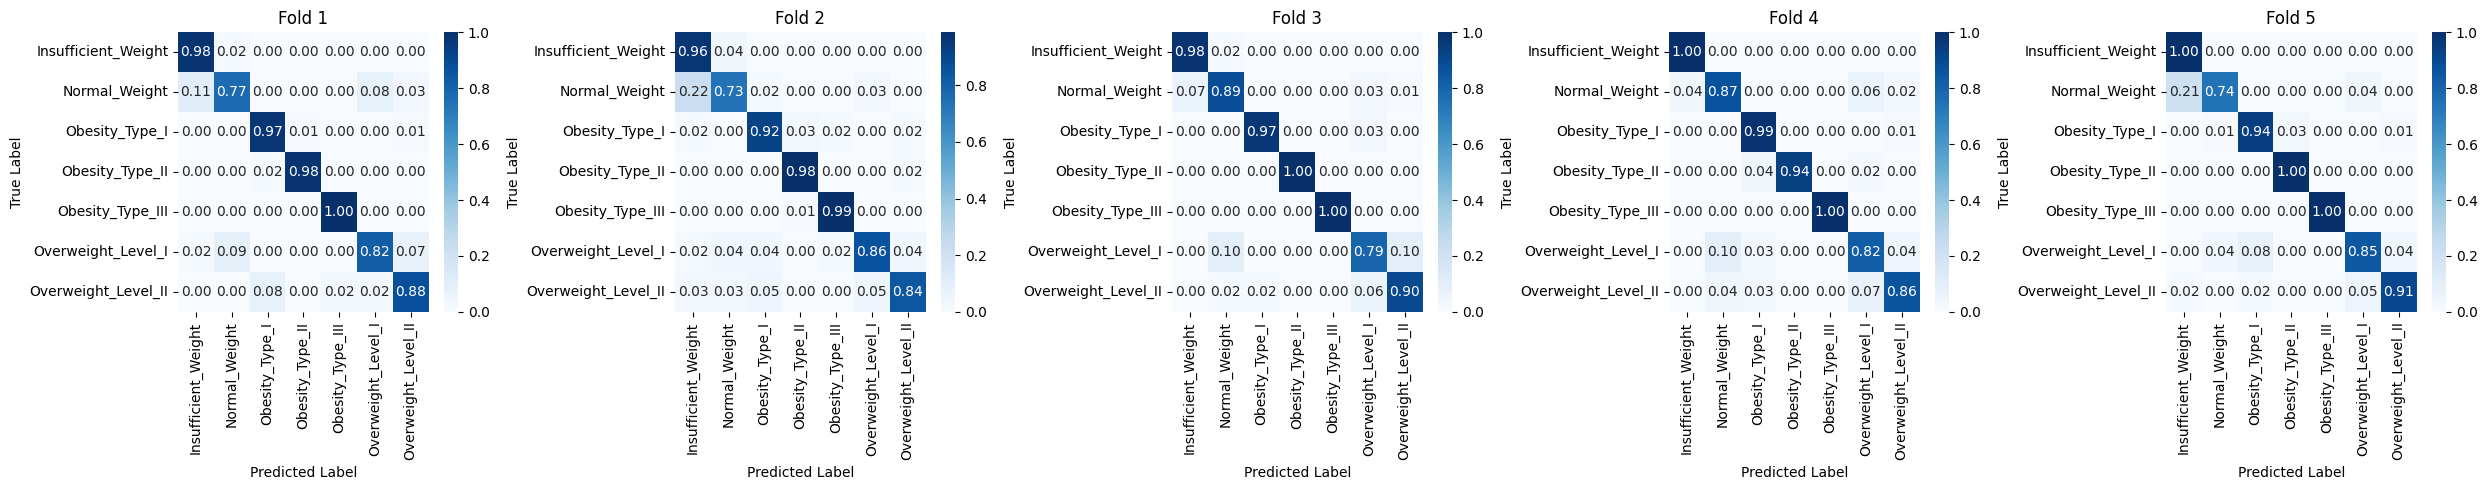

Avg Accuracy: 0.8000, Time: 71.27 sec for M = 31


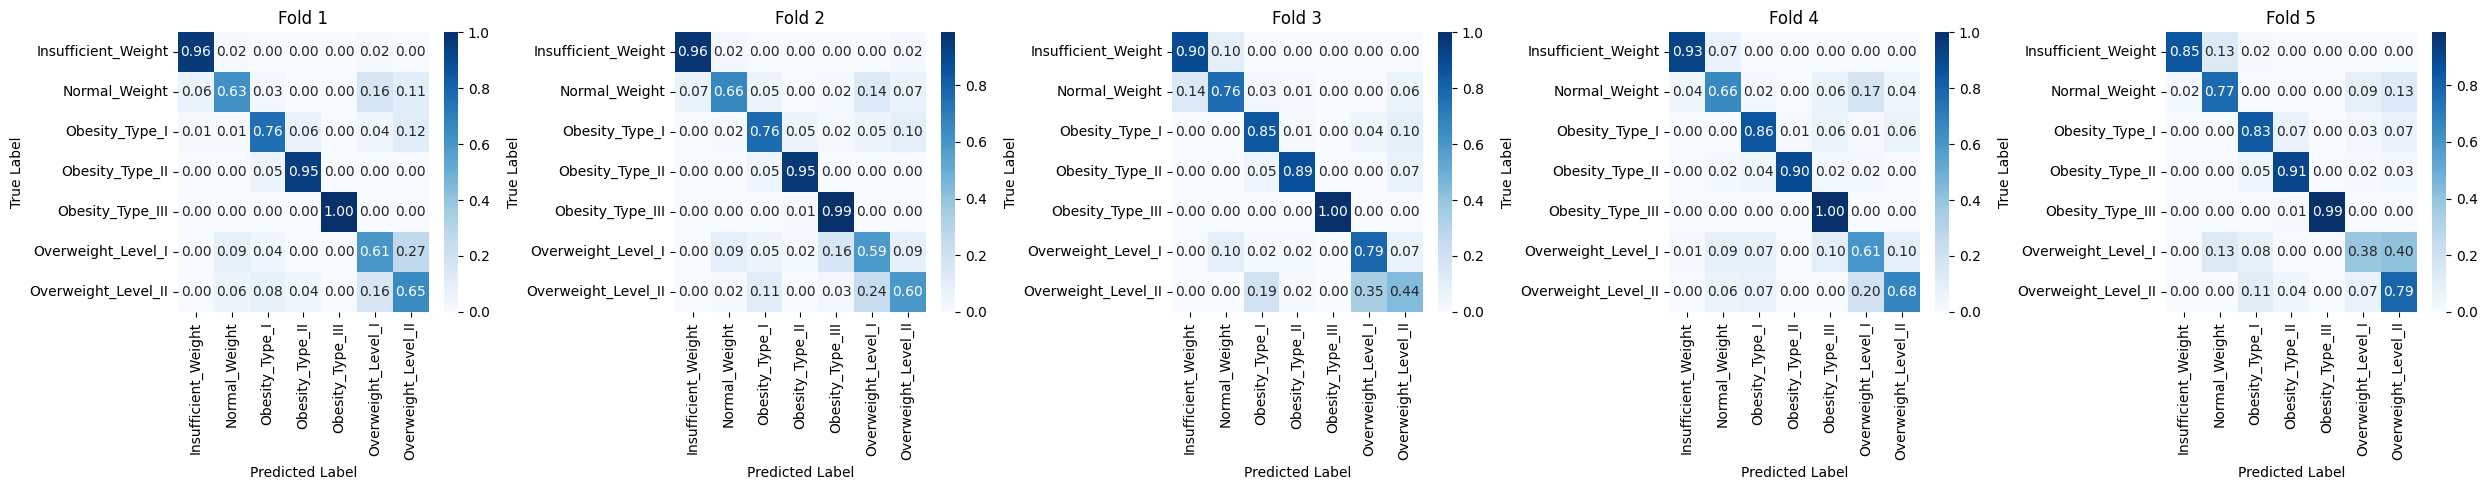

In [42]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# T = 50 trees
conf_matrices_50, avg_acc_50, duration_50 = k_fold_cross_validation_perceptron_forest(
    X=X_full_preprocessed_np,
    y=y_encoded,
    encoder=encoder,
    k_fold=5,
    n_trees=50,
    max_depth=25,
    M=6,
    random_state=42
)
print(f"Avg Accuracy: {avg_acc_50:.4f}, Time: {duration_50:.2f} sec for T = 50")
plot_confusion_matrices(conf_matrices_50, encoder.classes_, normalize=True)

# T = 100 trees
conf_matrices_100, avg_acc_100, duration_100 = k_fold_cross_validation_perceptron_forest(
    X=X_full_preprocessed_np,
    y=y_encoded,
    encoder=encoder,
    k_fold=5,
    n_trees=50,
    max_depth=25,
    M=12,
    random_state=42
)
print(f"Avg Accuracy: {avg_acc_100:.4f}, Time: {duration_100:.2f} sec for T = 100")
plot_confusion_matrices(conf_matrices_100, encoder.classes_, normalize=True)

# T = 150 trees
conf_matrices_150, avg_acc_150, duration_150 = k_fold_cross_validation_perceptron_forest(
    X=X_full_preprocessed_np,
    y=y_encoded,
    encoder=encoder,
    k_fold=5,
    n_trees=50,
    max_depth=25,
    M=18,
    random_state=42
)
print(f"Avg Accuracy: {avg_acc_150:.4f}, Time: {duration_150:.2f} sec for T = 150")
plot_confusion_matrices(conf_matrices_150, encoder.classes_, normalize=True)

# M = 6 features
conf_matrices_m6, avg_acc_m6, duration_m6 = k_fold_cross_validation_perceptron_forest(
    X=X_full_preprocessed_np,
    y=y_encoded,
    encoder=encoder,
    k_fold=5,
    n_trees=50,
    max_depth=25,
    M=6,
    random_state=42
)
print(f"Avg Accuracy: {avg_acc_m6:.4f}, Time: {duration_m6:.2f} sec for M = 6")
plot_confusion_matrices(conf_matrices_m6, encoder.classes_, normalize=True)

# M = 12 features
conf_matrices_m12, avg_acc_m12, duration_m12 = k_fold_cross_validation_perceptron_forest(
    X=X_full_preprocessed_np,
    y=y_encoded,
    encoder=encoder,
    k_fold=5,
    n_trees=50,
    max_depth=25,
    M=12,
    random_state=42
)
print(f"Avg Accuracy: {avg_acc_m12:.4f}, Time: {duration_m12:.2f} sec for M = 12")
plot_confusion_matrices(conf_matrices_m12, encoder.classes_, normalize=True)

# M = 18 features
conf_matrices_m18, avg_acc_m18, duration_m18 = k_fold_cross_validation_perceptron_forest(
    X=X_full_preprocessed_np,
    y=y_encoded,
    encoder=encoder,
    k_fold=5,
    n_trees=50,
    max_depth=25,
    M=18,
    random_state=42
)
print(f"Avg Accuracy: {avg_acc_m18:.4f}, Time: {duration_m18:.2f} sec for M = 18")
plot_confusion_matrices(conf_matrices_m18, encoder.classes_, normalize=True)

# M = 31 features
conf_matrices_m31, avg_acc_m31, duration_m31 = k_fold_cross_validation_perceptron_forest(
    X=X_full_preprocessed_np,
    y=y_encoded,
    encoder=encoder,
    k_fold=5,
    n_trees=50,
    max_depth=25,
    M=31,
    random_state=42
)
print(f"Avg Accuracy: {avg_acc_m31:.4f}, Time: {duration_m31:.2f} sec for M = 31")
plot_confusion_matrices(conf_matrices_m31, encoder.classes_, normalize=True)

## Comments:

When M = 15, the accuracies across different values of T were consistently good.
However, when T increased to 150, the accuracy dropped slightly.
This is likely due to overfitting or voting instability. With too many trees, especially deep ones, the model may start to memorize noise or introduce more conflicting decisions, which can reduce the overall ensemble performance.

When T is fixed at 50 and M increases, accuracy also increases.
This is because more features per tree allow the model to make better, more informed splits.
However, when M reaches 31 (the maximum, i.e., all features), the accuracy drops a lot.
This likely happens due to reduced randomness among trees, which makes the forest behave more like a single strong model rather than a diverse ensemble, weakening the benefit of aggregation and possibly leading to overfitting.

Compared with AdaBoost + MLP, the Perceptron-based forest is significantly faster when using the same number of trees.
This is because each node in the forest uses a lightweight Perceptron, which is a linear model and converges quickly, whereas MLPs involve multiple layers, nonlinear activations, and backpropagation, making each model in AdaBoost computationally heavier and slower to train.